# Setup

In [1]:
import numpy as np
import pandas as pd
import random
random.seed(123)

from tabulate import tabulate
from tqdm import tqdm
import json

from minisom import MiniSom as SOM
from datetime import datetime

%run Code/plot_setup.py

%reload_ext autoreload
%autoreload 2

fig_path = "Figures_Plots/"

# Data

In [2]:
# initialise data
etf_data = pd.read_csv("Data/Data_ETFs_Info.csv")
etf_returns = pd.read_parquet("Data/Data_ETFs_Returns.gzip")

with open("Data/Data_ETFs_Names.json", "r") as openfile:
    # Reading from json file
    etf_dict = json.load(openfile)
    

etf_symbols = etf_dict.get("symbols")
etf_names = etf_dict.get("names")

# dict to store subsets
subset_data = {
    "Universe": {"Small":etf_symbols["universe"], "Large":etf_symbols["universe"]},
    "SOM-Cluster": {},
    "Cluster": {},
    "SOM-MST": {},
    "MST": {}
}

## Train Test Split

In [3]:
from sklearn import preprocessing

# date where train ends
train_test_split = "2019-01-01"
# train_test_split = datetime.strptime(train_test_split, "%Y-%m-%d").date()

# train test split
train_returns = etf_returns.loc[etf_returns.index < train_test_split, :]
test_returns = etf_returns.loc[etf_returns.index >= train_test_split, :]


# Should we standardize test with train ?
train_st_returns = train_returns.apply(preprocessing.scale)
test_st_returns = test_returns.apply(preprocessing.scale)

print(f"Train returns shape: \t{train_returns.shape}")
print(f"Test returns shape: \t{test_returns.shape}")

Train returns shape: 	(207, 663)
Test returns shape: 	(205, 663)


# Train returns statistics

In [4]:
from Code.functions import get_annualized_returns, get_annualized_std, sharpe_ratio, starr_ratio

etf_data["Annualized mean returns"] = get_annualized_returns(train_returns[etf_symbols["universe"]], "weekly")
etf_data["Annualized std"] = get_annualized_std(train_returns[etf_symbols["universe"]], "weekly")
etf_data["Annualized sharpe"] = sharpe_ratio(train_returns[etf_symbols["universe"]], "weekly")

etf_data["Annualized starr"] = starr_ratio(train_returns[etf_symbols["universe"]], "weekly")

# SOM (Map)

In [5]:
from Code.som_plots import expandgrid, som_params_tune

# data for som
train_data = train_st_returns[etf_symbols["universe"]].values.T
assetclasses = etf_data[etf_data["Symbol"].isin(etf_symbols["universe"])]["Asset Class"].to_list()

# params = {
#     "x": [11],
#     "y": [11],
#     "input_len": [train_data.shape[1]],
#     "sigma": np.linspace(1,2.5, num = 10),
#     "learning_rate": np.linspace(0.05,0.5, num = 10),
#     "iterations": [20000]
# }

# params_grid = expandgrid(params)

# best_params, som_errors = som_params_tune(
#     train_data = train_data,
#     params_grid = params_grid
# )


In [6]:
best_params = {'x': 11.0,
 'y': 11.0,
 'input_len': 207.0,
 'sigma': 1.0,
 'learning_rate': 0.5,
 'iterations': 20000.0}

best_params

{'x': 11.0,
 'y': 11.0,
 'input_len': 207.0,
 'sigma': 1.0,
 'learning_rate': 0.5,
 'iterations': 20000.0}

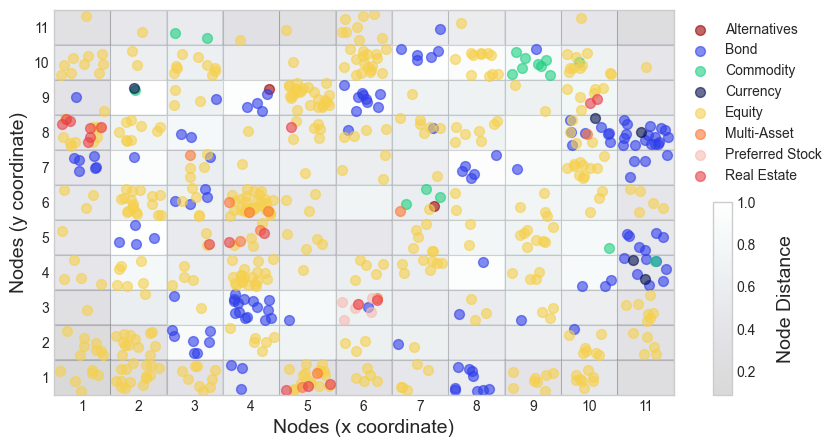

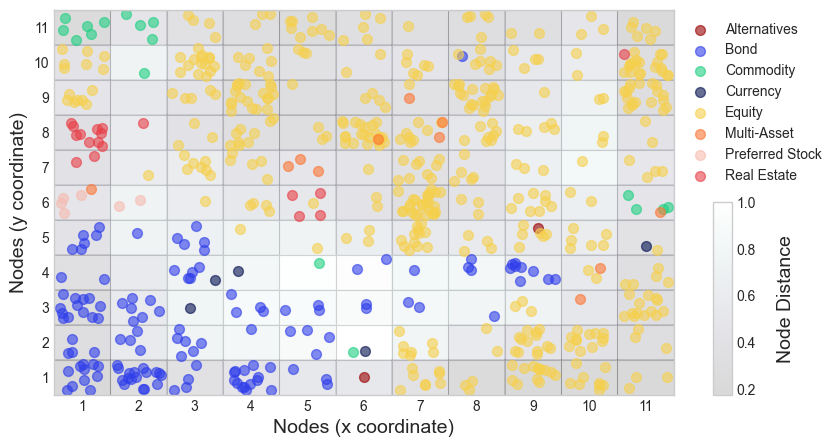

In [7]:
from IPython.display import clear_output
from Code.som_plots import *

# initialize som
som_shape = (int(best_params["x"]), int(best_params["y"]))
som = SOM(
    x = int(best_params["x"]),
    y = int(best_params["y"]),
    input_len = int(best_params["input_len"]),
    sigma = best_params["sigma"],
    learning_rate = best_params["learning_rate"],
    random_seed = 123
)

# initialize weights (randomly)
som.random_weights_init(train_data)

plot_nodemap(
    som = som, 
    data = train_data, 
    returns = train_returns, 
    st_returns = train_st_returns,
    symbols = etf_symbols,
    assetclasses = assetclasses,
    # clusters = node_cluster_labels, 
    #title = "SOM Map (Pre-Training)"
)
plt.savefig(fig_path + 'SOMmap_nodemap_pretrain.png', bbox_inches='tight')

# clear_output(wait=True)
som.train(train_data, int(best_params["iterations"]), random_order=True, verbose=False)  # random training  

plot_nodemap(
    som = som, 
    data = train_data, 
    returns = train_returns, 
    st_returns = train_st_returns,
    symbols = etf_symbols,
    assetclasses = assetclasses,
    # clusters = node_cluster_labels, 
    #title = "SOM Map (Post-Training)"
)
plt.savefig(fig_path + 'SOMmap_nodemap_posttrain.png', bbox_inches='tight')

## Optimal number of clusters

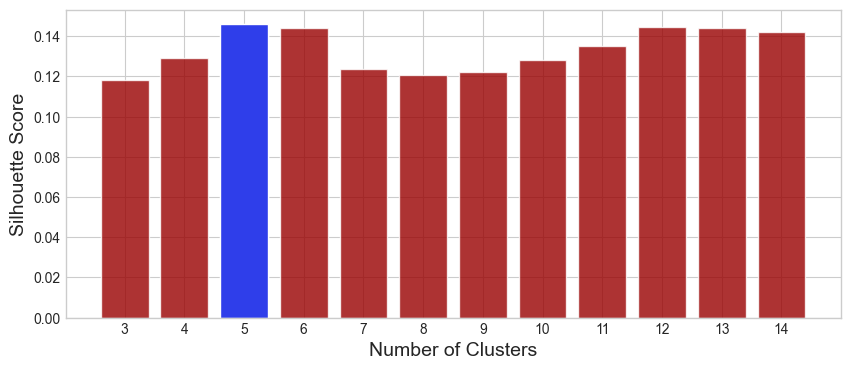

In [8]:
from sklearn.metrics import silhouette_samples, silhouette_score  
from Code.som_plots import som_cluster

node_weights = som.get_weights().reshape((som_shape[0]*som_shape[1], train_data.shape[1]))

silhouette_avg = []
n_clusters_list = np.arange(3,15)
for i in n_clusters_list:
    # Apply the clustering algorithm to the node positions to extract the clusters
    node_cluster_labels = som_cluster(node_weights, n_clusters = i)
    silhouette_avg.append(silhouette_score(node_weights, node_cluster_labels))
    
plt.bar(n_clusters_list, silhouette_avg, alpha = 0.8)

max_idx = silhouette_avg.index(max(silhouette_avg))
plt.bar(n_clusters_list[max_idx], silhouette_avg[max_idx])
plt.xticks(n_clusters_list)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
#plt.title("SOM Node Silhouette Score")

plt.savefig(fig_path + 'SOM+Cluster_silhouette.png', bbox_inches='tight')
plt.show()

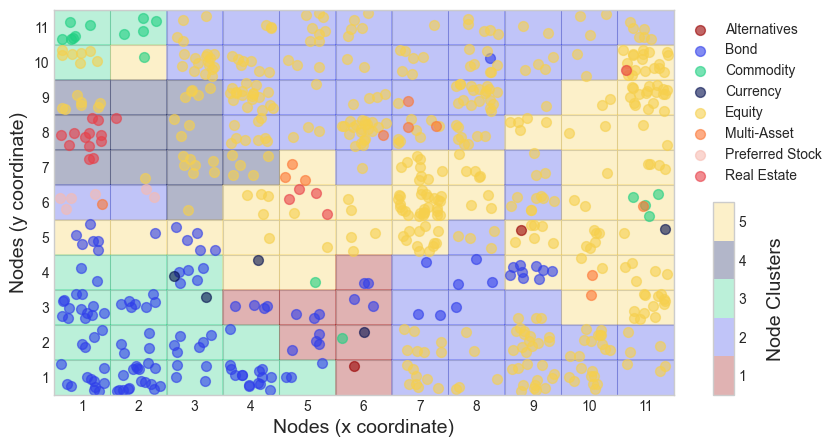

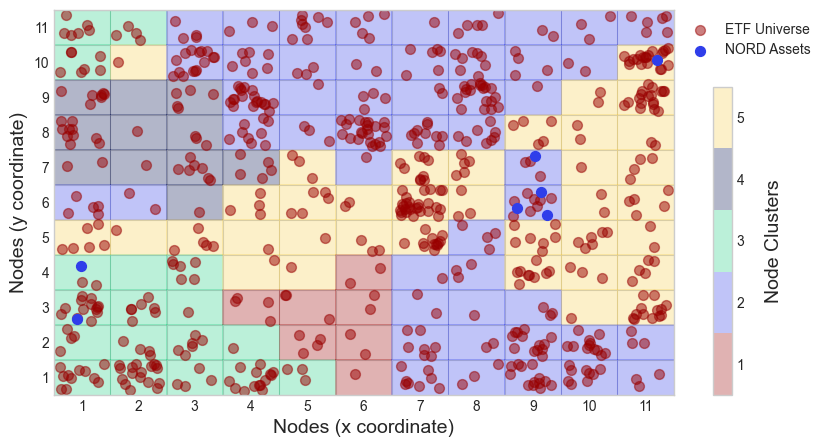

In [9]:
from Code.som_plots import plot_cluster_nodemap

n_clusters = 5
node_cluster_labels = som_cluster(node_weights, n_clusters = n_clusters)

plot_cluster_nodemap(
    som = som, 
    data = train_data, 
    returns = train_returns, 
    st_returns = train_st_returns,
    symbols = etf_symbols,
    assetclasses = assetclasses,
    clusters = node_cluster_labels, 
    #title = "SOM Map (Post-Training)"
)

plt.savefig(fig_path + 'SOM+Cluster_nodemap_clusters.png', bbox_inches='tight')


plot_cluster_nodemap(
    som = som, 
    data = train_data, 
    returns = train_returns, 
    st_returns = train_st_returns,
    symbols = etf_symbols,
    #assetclasses = assetclasses,
    clusters = node_cluster_labels, 
    #title = "SOM Map (Post-Training)"
)

plt.savefig(fig_path + 'SOM+Cluster_nodemap_clusters_wNORD.png', bbox_inches='tight')

## Cluster insights

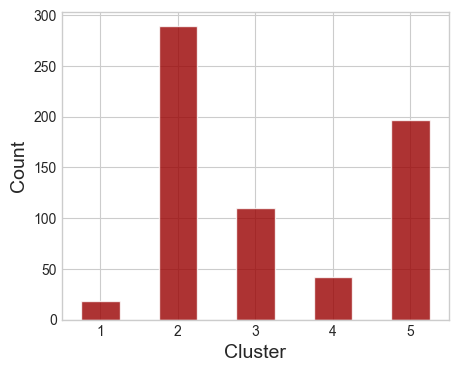

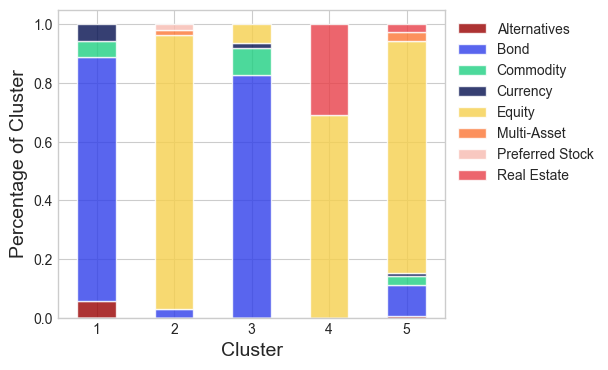

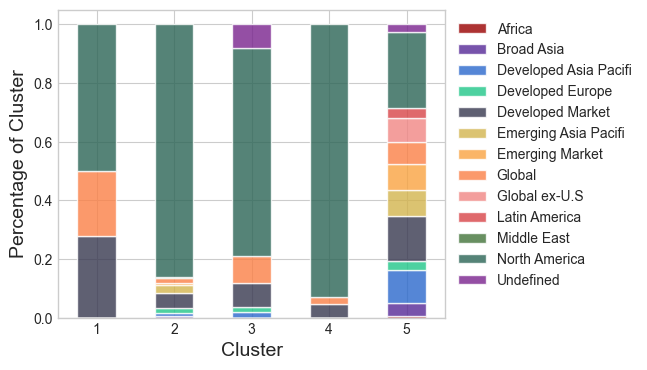

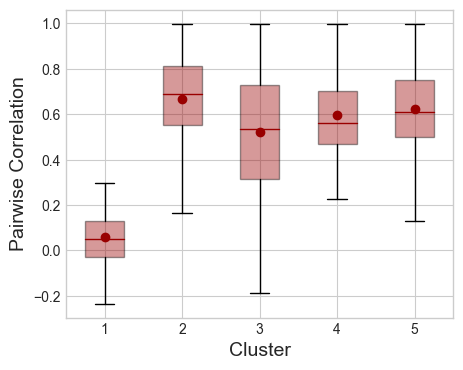

In [10]:

n_clusters = 5
node_cluster_labels = som_cluster(node_weights, n_clusters = n_clusters)
cluster_labels = get_som_clusters(som, train_data, node_cluster_labels)


etf_data["Cluster"] = cluster_labels

info_figsize = (5,4)

# fig density (1)
fig, ax = plt.subplots(figsize = info_figsize)
etf_data.value_counts("Cluster", sort = False).plot(kind = "bar", legend = False, ax = ax, alpha = 0.8)
#plt.title("Density")
plt.xticks(rotation = 0)
plt.xlabel("Cluster")
plt.ylabel("Count")

plt.savefig(fig_path + 'SOM+Cluster_info_(1).png', bbox_inches='tight')
plt.show()


# fig asset (2)
fig, ax = plt.subplots(figsize = info_figsize)
df = etf_data.groupby("Cluster")["Asset Class"].value_counts(normalize = True).to_frame()
df.columns = ["Count"]
df = df.reset_index().pivot(index = "Cluster", columns = "Asset Class", values = "Count")

df.plot(kind = "bar", stacked = True, ax = ax, alpha = 0.8)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.title("Asset Class Distribution")
plt.xticks(rotation = 0)
plt.xlabel("Cluster")
plt.ylabel("Percentage of Cluster")

plt.savefig(fig_path + 'SOM+Cluster_info_(2).png', bbox_inches='tight')
plt.show()



# fig region (3)
fig, ax = plt.subplots(figsize = info_figsize)
df = etf_data.groupby("Cluster")["region"].value_counts(normalize = True).to_frame()
df.columns = ["Count"]
df = df.reset_index().pivot(index = "Cluster", columns = "region", values = "Count")

df.plot(kind = "bar", stacked = True, ax = ax, alpha = 0.8, cmap = "dtu_colors_medium")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.title("Regional Distribution")
plt.xticks(rotation = 0)
plt.xlabel("Cluster")
plt.ylabel("Percentage of Cluster")

plt.savefig(fig_path + 'SOM+Cluster_info_(3).png', bbox_inches='tight')
plt.show()


# get pairvise correlation
pair_mean_corr = []
pair_corr = []
for cluster in np.unique(cluster_labels):
    
    cluster_returns = train_returns[etf_symbols["universe"]].iloc[:, cluster_labels == cluster]
    cluster_symbols = cluster_returns.columns.to_list()
    
    cluster_corr = cluster_returns.corr("spearman")
    
    pair_corr.append(cluster_corr.values[np.triu_indices(n = len(cluster_symbols), k=1)])
    pair_mean_corr.append(cluster_corr.values[np.triu_indices(n = len(cluster_symbols), k=1)].mean())

    
    
# fig corr (4)
fig, ax = plt.subplots(figsize = info_figsize)
meanprops = dict(marker='o', markerfacecolor = colors["DTU Red"], markeredgecolor = colors["DTU Red"])
bp = ax.boxplot(
    pair_corr, showfliers=False,
    medianprops=dict(color = colors["DTU Red"]),
    showmeans=True, meanline=False, meanprops=meanprops,
    patch_artist=True,
)
for patch in bp['boxes']:
    patch.set_facecolor(colors["DTU Red"])
    patch.set_alpha(0.4)

plt.xlabel("Cluster")
plt.ylabel("Pairwise Correlation")
#plt.title("Pairwise Correlation")

#plt.savefig(fig_path + 'Cluster_small_correlation_boxplot.png', bbox_inches='tight')
plt.savefig(fig_path + 'SOM+Cluster_info_(4).png', bbox_inches='tight')
plt.show()

# SOM Cluster

### Small

In [11]:
from Code.som_plots import *
from Code.som_plots import get_som_clusters
import heapq as hq

n_clusters = 5
node_cluster_labels = som_cluster(node_weights, n_clusters = n_clusters)
cluster_labels = get_som_clusters(som, train_data, node_cluster_labels)

n_from_cluster = 3
n_min_cluster = 50

som_cluster_subset = []
for cluster in np.unique(cluster_labels):
    
    cluster_df = train_returns[etf_symbols["universe"]].iloc[:, cluster_labels == cluster]
    cluster_symbols = cluster_df.columns.to_list()
    
    if len(cluster_symbols) >= n_min_cluster:     
        
        sharpe_returns = cluster_df
        sharpe_etfs = sharpe_returns.columns.to_list()

        sharpe = list(sharpe_ratio(sharpe_returns, "weekly"))
        n_largest_sharpe = hq.nlargest(n_from_cluster, sharpe)
        sharpe_winners = [sharpe_etfs[sharpe.index(s)] for s in n_largest_sharpe]

        starr_returns = sharpe_returns.loc[:, ~sharpe_returns.columns.isin(sharpe_winners)]
        starr_etfs = starr_returns.columns.to_list()

        starr = list(starr_ratio(starr_returns, "weekly"))
        n_largest_starr = hq.nlargest(n_from_cluster, starr)
        starr_winners = [starr_etfs[starr.index(s)] for s in n_largest_starr]

        cluster_winners = set(sharpe_winners + starr_winners)

        som_cluster_subset.extend(cluster_winners)
    else:
        
        # cluster_sharpe_ratios = sharpe_ratio(mst_cluster_df, "weekly")
        cluster_starr = list(starr_ratio(cluster_df, "weekly"))
        n_largest_starr = hq.nlargest(n_from_cluster, cluster_starr)
        
        cluster_winners = [cluster_symbols[cluster_starr.index(s)] for s in n_largest_starr]
        
        som_cluster_subset.extend(cluster_winners)

    
subset_data["SOM-Cluster"]["Small"] = som_cluster_subset

# plot_subset_heatmap(train_returns, som_cluster_subset, sub_type = "SOM-Cluster")
# plt.savefig(fig_path + 'SOM+Cluster_small_subset_heatmap.png', bbox_inches='tight')

### Large

In [12]:
from Code.som_plots import *
from Code.som_plots import get_som_clusters
import heapq as hq

n_clusters = 5
node_cluster_labels = som_cluster(node_weights, n_clusters = n_clusters)
cluster_labels = get_som_clusters(som, train_data, node_cluster_labels)

n_from_cluster = 5
n_min_cluster = 50

som_cluster_subset = []
for cluster in np.unique(cluster_labels):
    
    cluster_df = train_returns[etf_symbols["universe"]].iloc[:, cluster_labels == cluster]
    cluster_symbols = cluster_df.columns.to_list()
    
    if len(cluster_symbols) >= n_min_cluster:     
        
        sharpe_returns = cluster_df
        sharpe_etfs = sharpe_returns.columns.to_list()

        sharpe = list(sharpe_ratio(sharpe_returns, "weekly"))
        n_largest_sharpe = hq.nlargest(n_from_cluster, sharpe)
        sharpe_winners = [sharpe_etfs[sharpe.index(s)] for s in n_largest_sharpe]

        starr_returns = sharpe_returns.loc[:, ~sharpe_returns.columns.isin(sharpe_winners)]
        starr_etfs = starr_returns.columns.to_list()

        starr = list(starr_ratio(starr_returns, "weekly"))
        n_largest_starr = hq.nlargest(n_from_cluster, starr)
        starr_winners = [starr_etfs[starr.index(s)] for s in n_largest_starr]

        cluster_winners = set(sharpe_winners + starr_winners)

        som_cluster_subset.extend(cluster_winners)
    else:
        
        # cluster_sharpe_ratios = sharpe_ratio(mst_cluster_df, "weekly")
        cluster_starr = list(starr_ratio(cluster_df, "weekly"))
        n_largest_starr = hq.nlargest(n_from_cluster, cluster_starr)
        
        cluster_winners = [cluster_symbols[cluster_starr.index(s)] for s in n_largest_starr]
        
        som_cluster_subset.extend(cluster_winners)

    
subset_data["SOM-Cluster"]["Large"] = som_cluster_subset

# plot_subset_heatmap(train_returns, som_cluster_subset, sub_type = "SOM-Cluster")
# plt.savefig(fig_path + 'SOM+Cluster_large_subset_heatmap.png', bbox_inches='tight')

### Overview

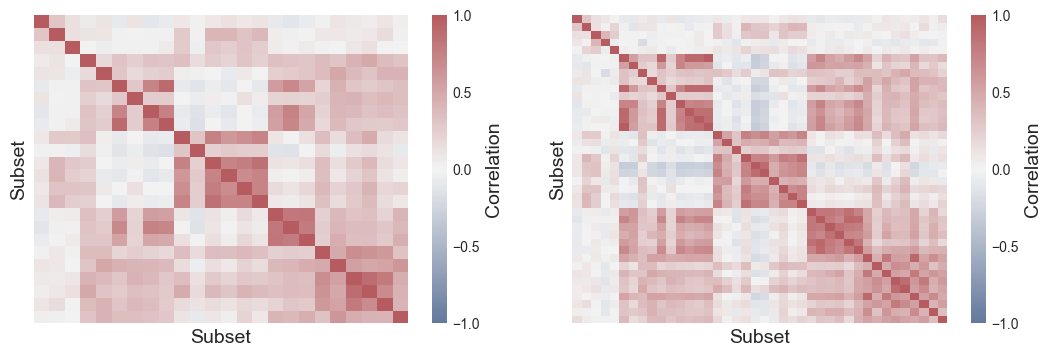

In [13]:
from Code.som_plots import plot_subset_heatmaps

plot_subset_heatmaps(train_returns, subset = subset_data["SOM-Cluster"], sub_type = "SOM-Cluster")
plt.savefig(fig_path + 'SOM+Cluster_both_subset_heatmap.png', bbox_inches='tight')

In [14]:
from Code.functions import compare_subset_stat

tab = compare_subset_stat(train_returns, subset_data["SOM-Cluster"])
print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrr}
\hline
                             &   Small Subset &   Large Subset \\
\hline
 n                           &          24.00 &          40.00 \\
 Avg. annualized returns (\%) &           5.20 &           5.72 \\
 Avg. annualized std (\%)     &           5.41 &           6.36 \\
 Avg. Sharpe Ratio           &           1.48 &           1.36 \\
 Avg. Starr Ratio            &           5.60 &           5.13 \\
 PDI                         &           8.34 &          10.20 \\
 Avg. pair-wise correlation  &           0.24 &           0.23 \\
\hline
\end{tabular}


In [15]:
# Region
tab = etf_data[etf_data["Symbol"].isin(subset_data["SOM-Cluster"]["Large"])].value_counts("region")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))
print("\n")

# Asset class
tab = etf_data[etf_data["Symbol"].isin(subset_data["SOM-Cluster"]["Large"])].value_counts("Asset Class")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", intfmt="0.0f", tablefmt = "latex"))
print("\n")

# Region
tab = etf_data[etf_data["Symbol"].isin(subset_data["SOM-Cluster"]["Small"])].value_counts("region")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))
print("\n")

# Asset class
tab = etf_data[etf_data["Symbol"].isin(subset_data["SOM-Cluster"]["Small"])].value_counts("Asset Class")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", intfmt="0.0f", tablefmt = "latex"))

\begin{tabular}{lrr}
\hline
 region           &   Count &   Ratio (\%) \\
\hline
 North America    &   27.00 &       67.50 \\
 Developed Market &    6.00 &       15.00 \\
 Emerging Market  &    3.00 &        7.50 \\
 Global           &    2.00 &        5.00 \\
 Global ex-U.S    &    2.00 &        5.00 \\
\hline
\end{tabular}


\begin{tabular}{lrr}
\hline
 Asset Class     &   Count &   Ratio (\%) \\
\hline
 Bond            &   26.00 &       65.00 \\
 Equity          &   13.00 &       32.50 \\
 Preferred Stock &    1.00 &        2.50 \\
\hline
\end{tabular}


\begin{tabular}{lrr}
\hline
 region           &   Count &   Ratio (\%) \\
\hline
 North America    &   15.00 &       62.50 \\
 Developed Market &    4.00 &       16.67 \\
 Emerging Market  &    3.00 &       12.50 \\
 Global           &    1.00 &        4.17 \\
 Global ex-U.S    &    1.00 &        4.17 \\
\hline
\end{tabular}


\begin{tabular}{lrr}
\hline
 Asset Class     &   Count &   Ratio (\%) \\
\hline
 Bond            &   17.00 

# SOM MST

In [16]:
from Code.som_plots import som_mst
from Code.functions import get_pdi, sharpe_ratio

mst_df = pd.DataFrame(node_weights).T.loc[:, som.activation_response(train_data).flatten() > 0]
node_mst_subset = mst_df.columns.to_list()

run = 0
tab = {
    "Iteration": [],
    "No. of Nodes": [],
    "No. of Assets": [],
    "PDI": [],
    "Avg. Sharpe Ratio": [],
    "Avg. Starr Ratio": []
}
while len(node_mst_subset) > 2:
    run += 1
    # node_mst_subset, mst_df,_,_ = minimum_spanning_tree(mst_df)
    node_mst_subset, mst_df = som_mst(mst_df)
    
    n_etfs = 0
    iter_idxs = []
    for node in node_mst_subset:
        node_coordinate = np.unravel_index(node, shape = som_shape)
        node_etfs_idx = som.win_map(train_data, return_indices=True).get(node_coordinate)
        
        iter_idxs.extend(node_etfs_idx)
        n_etfs += len(node_etfs_idx)
        
    iter_returns = train_returns.iloc[:, iter_idxs]
    
    tab["Iteration"].append(run)
    tab["No. of Nodes"].append(len(node_mst_subset)) 
    tab["No. of Assets"].append(n_etfs)
    tab["PDI"].append(get_pdi(iter_returns))
    tab["Avg. Sharpe Ratio"].append(sharpe_ratio(iter_returns, "weekly").mean())
    tab["Avg. Starr Ratio"].append(starr_ratio(iter_returns, "weekly").mean())
    

print(tabulate(tab, headers="keys", floatfmt="0.2f", tablefmt = "simple"))

  Iteration    No. of Nodes    No. of Assets    PDI    Avg. Sharpe Ratio    Avg. Starr Ratio
-----------  --------------  ---------------  -----  -------------------  ------------------
          1              57              186  20.77                 0.31                1.09
          2              27               92  14.57                 0.27                0.83
          3              14               51   9.22                 0.24                0.75
          4               7               27   5.81                 0.21                0.74
          5               4               12   3.40                 0.16                0.66
          6               3               11   2.90                 0.19                0.79
          7               2                8   2.09                 0.36                1.34


### Small

In [17]:
from Code.som_plots import som_mst

from Code.functions import get_pdi, sharpe_ratio
from Code.som_plots import plot_subset_heatmap
import heapq as hq
    
mst_df = pd.DataFrame(node_weights).T.loc[:, som.activation_response(train_data).flatten() > 0]
node_mst_subset = mst_df.columns.to_list()

run = 2
for i in range(run):
    # node_mst_subset, mst_df,_,_ = minimum_spanning_tree(mst_df)
    node_mst_subset, mst_df = som_mst(mst_df)
    

n_from_node = 1
som_mst_subset = []
for node in node_mst_subset:

    node_coordinate = np.unravel_index(node, shape = som_shape)
    node_etfs_idx = som.win_map(train_data, return_indices=True).get(node_coordinate)
    
    starr_returns = train_returns.iloc[:, node_etfs_idx]
    starr_etfs = starr_returns.columns.to_list()

    starr = list(starr_ratio(starr_returns, "weekly"))
    n_largest_starr = hq.nlargest(n_from_node, starr)
    starr_winners = [starr_etfs[starr.index(s)] for s in n_largest_starr]

    cluster_winner_etf = list(starr_winners)

    som_mst_subset.extend(cluster_winner_etf)

subset_data["SOM-MST"]["Small"] = som_mst_subset

# plot_subset_heatmap(train_returns, som_mst_subset, sub_type = "SOM-MST")
# plt.savefig(fig_path + 'SOM+MST_small_subset_heatmap.png', bbox_inches='tight')

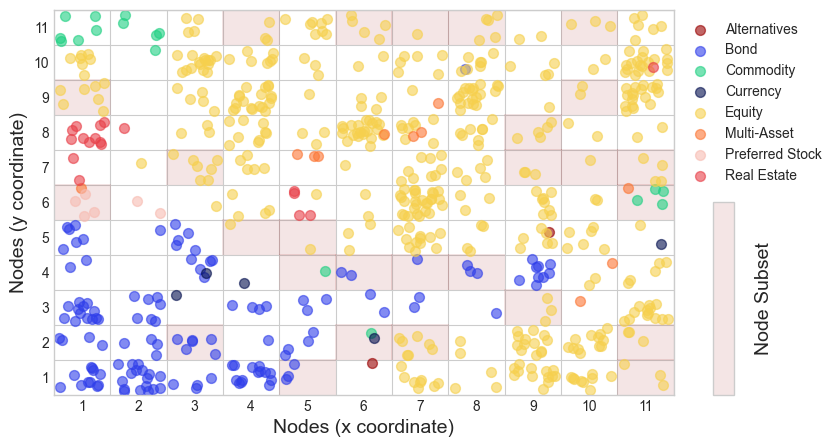

In [18]:
from Code.som_plots import plot_mst_nodemap

plot_mst_nodemap(
    som = som, 
    data = train_data, 
    returns = train_returns, 
    st_returns = train_st_returns,
    symbols = etf_symbols,
    # assetclasses = assetclasses,
    node_subset = node_mst_subset, 
    #title = "SOM Map (Post-Training)",
    assetclasses=assetclasses
)
plt.savefig(fig_path + 'SOM+MST_nodemap_small.png', bbox_inches='tight')

### Large

In [19]:
from Code.som_plots import som_mst

from Code.functions import get_pdi, sharpe_ratio
from Code.som_plots import plot_subset_heatmap
import heapq as hq
    
mst_df = pd.DataFrame(node_weights).T.loc[:, som.activation_response(train_data).flatten() > 0]
node_mst_subset = mst_df.columns.to_list()

run = 1
for i in range(run):
    # node_mst_subset, mst_df,_,_ = minimum_spanning_tree(mst_df)
    node_mst_subset, mst_df = som_mst(mst_df)
    

n_from_node = 1
som_mst_subset = []
for node in node_mst_subset:

    node_coordinate = np.unravel_index(node, shape = som_shape)
    node_etfs_idx = som.win_map(train_data, return_indices=True).get(node_coordinate)
    
    starr_returns = train_returns.iloc[:, node_etfs_idx]
    starr_etfs = starr_returns.columns.to_list()

    starr = list(starr_ratio(starr_returns, "weekly"))
    n_largest_starr = hq.nlargest(n_from_node, starr)
    starr_winners = [starr_etfs[starr.index(s)] for s in n_largest_starr]

    cluster_winner_etf = list(starr_winners)

    som_mst_subset.extend(cluster_winner_etf)

subset_data["SOM-MST"]["Large"] = som_mst_subset

# plot_subset_heatmap(train_returns, som_mst_subset, sub_type = "SOM-MST")
# plt.savefig(fig_path + 'SOM+MST_large_subset_heatmap.png', bbox_inches='tight')

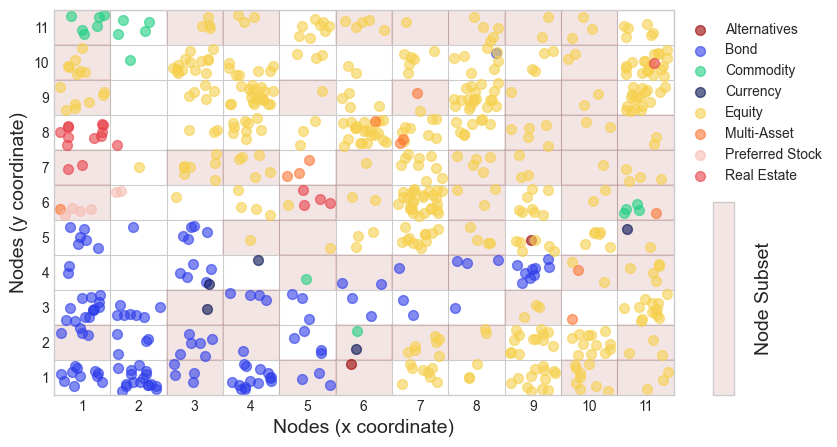

In [20]:
from Code.som_plots import plot_mst_nodemap

plot_mst_nodemap(
    som = som, 
    data = train_data, 
    returns = train_returns, 
    st_returns = train_st_returns,
    symbols = etf_symbols,
    # assetclasses = assetclasses,
    node_subset = node_mst_subset, 
    #title = "SOM Map (Post-Training)",
    assetclasses=assetclasses
)

plt.savefig(fig_path + 'SOM+MST_nodemap_large.png', bbox_inches='tight')

### Overview

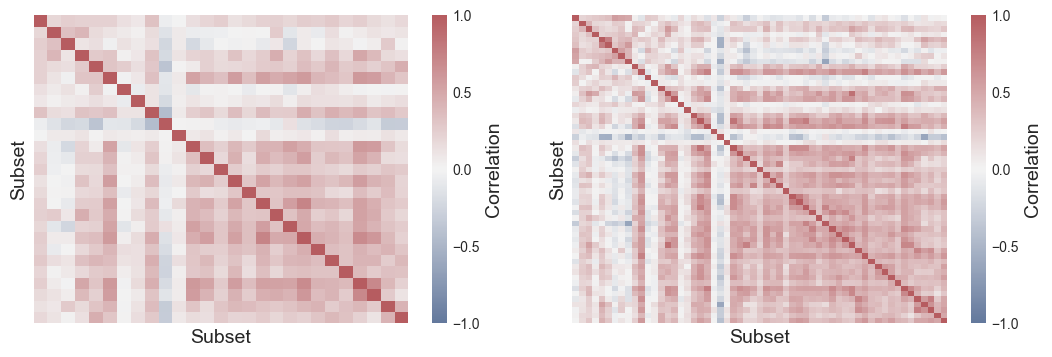

In [21]:
from Code.som_plots import plot_subset_heatmaps

plot_subset_heatmaps(train_returns, subset = subset_data["SOM-MST"], sub_type = "SOM-MST")
plt.savefig(fig_path + 'SOM+MST_both_subset_heatmap.png', bbox_inches='tight')

In [22]:
from Code.functions import compare_subset_stat

tab = compare_subset_stat(train_returns, subset_data["SOM-MST"])
print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrr}
\hline
                             &   Small Subset &   Large Subset \\
\hline
 n                           &          27.00 &          57.00 \\
 Avg. annualized returns (\%) &           2.50 &           2.93 \\
 Avg. annualized std (\%)     &          15.64 &          15.26 \\
 Avg. Sharpe Ratio           &           0.37 &           0.43 \\
 Avg. Starr Ratio            &           1.19 &           1.50 \\
 PDI                         &          12.74 &          17.69 \\
 Avg. pair-wise correlation  &           0.21 &           0.25 \\
\hline
\end{tabular}


In [23]:
# Region
tab = etf_data[etf_data["Symbol"].isin(subset_data["SOM-MST"]["Large"])].value_counts("region")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))
print("\n")

# Asset class
tab = etf_data[etf_data["Symbol"].isin(subset_data["SOM-MST"]["Large"])].value_counts("Asset Class")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", intfmt="0.0f", tablefmt = "latex"))
print("\n")

# Region
tab = etf_data[etf_data["Symbol"].isin(subset_data["SOM-MST"]["Small"])].value_counts("region")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))
print("\n")

# Asset class
tab = etf_data[etf_data["Symbol"].isin(subset_data["SOM-MST"]["Small"])].value_counts("Asset Class")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", intfmt="0.0f", tablefmt = "latex"))

\begin{tabular}{lrr}
\hline
 region                &   Count &   Ratio (\%) \\
\hline
 North America         &   31.00 &       54.39 \\
 Developed Market      &    6.00 &       10.53 \\
 Global                &    5.00 &        8.77 \\
 Developed Asia Pacifi &    4.00 &        7.02 \\
 Emerging Asia Pacifi  &    4.00 &        7.02 \\
 Latin America         &    2.00 &        3.51 \\
 Undefined             &    2.00 &        3.51 \\
 Developed Europe      &    1.00 &        1.75 \\
 Emerging Market       &    1.00 &        1.75 \\
 Middle East           &    1.00 &        1.75 \\
\hline
\end{tabular}


\begin{tabular}{lrr}
\hline
 Asset Class     &   Count &   Ratio (\%) \\
\hline
 Equity          &   38.00 &       66.67 \\
 Bond            &    9.00 &       15.79 \\
 Currency        &    3.00 &        5.26 \\
 Commodity       &    2.00 &        3.51 \\
 Multi-Asset     &    2.00 &        3.51 \\
 Alternatives    &    1.00 &        1.75 \\
 Preferred Stock &    1.00 &        1.75 \\
 Re

# Benchmarks and Comparison

## MST

In [24]:
from Investment_Funnel_SOM.models.MST import minimum_spanning_tree

max_n_subset = 30

mst_df = train_st_returns[etf_symbols["universe"]]
mst_subset = [None for _ in range(max_n_subset + 1)]

run = 0
tab = {
    "Iteration": [],
    "No. of Assets": [],
    "PDI": [],
    "Avg. Sharpe Ratio": [],
    "Avg. Starr Ratio": []
}
while len(mst_subset) > 2:
    run += 1
    mst_subset, mst_df, _, _ = minimum_spanning_tree(mst_df)
    
    tab["Iteration"].append(run)
    tab["No. of Assets"].append(len(mst_subset))
    
    iter_returns = train_returns.loc[:, mst_subset]
    tab["PDI"].append(get_pdi(iter_returns))
    tab["Avg. Sharpe Ratio"].append(sharpe_ratio(iter_returns, "weekly").mean())
    tab["Avg. Starr Ratio"].append(starr_ratio(iter_returns, "weekly").mean())
    
    
print(tabulate(tab, headers="keys", floatfmt="0.2f", tablefmt = "simple"))

  Iteration    No. of Assets    PDI    Avg. Sharpe Ratio    Avg. Starr Ratio
-----------  ---------------  -----  -------------------  ------------------
          1              281  23.03                 0.35                1.12
          2              138  22.99                 0.37                1.25
          3               82  22.41                 0.44                1.54
          4               43  19.18                 0.39                1.38
          5               21  13.08                 0.34                1.14
          6               12   8.89                 0.31                1.08
          7                7   6.04                 0.56                1.89
          8                3   2.88                 0.67                2.19
          9                2   1.91                 0.08                0.07


### Small

In [25]:
from Investment_Funnel_SOM.models.MST import minimum_spanning_tree

mst_df = train_st_returns[etf_symbols["universe"]]
mst_subset = etf_symbols["universe"]

for _ in range(5):
    mst_subset, mst_df, _, _ = minimum_spanning_tree(mst_df)

subset_data["MST"]["Small"] = mst_subset

# plot_subset_heatmap(train_returns, subset = mst_subset, sub_type = "MST")
# plt.savefig(fig_path + 'MST_small_subset_heatmap.png', bbox_inches='tight')

### Large

In [26]:
from Investment_Funnel_SOM.models.MST import minimum_spanning_tree

mst_df = train_st_returns[etf_symbols["universe"]]
mst_subset = etf_symbols["universe"]

for _ in range(4):
    mst_subset, mst_df, _, _ = minimum_spanning_tree(mst_df)

subset_data["MST"]["Large"] = mst_subset

# plot_subset_heatmap(train_returns, subset = mst_subset, sub_type = "MST")
# plt.savefig(fig_path + 'MST_large_subset_heatmap.png', bbox_inches='tight')

### Overview

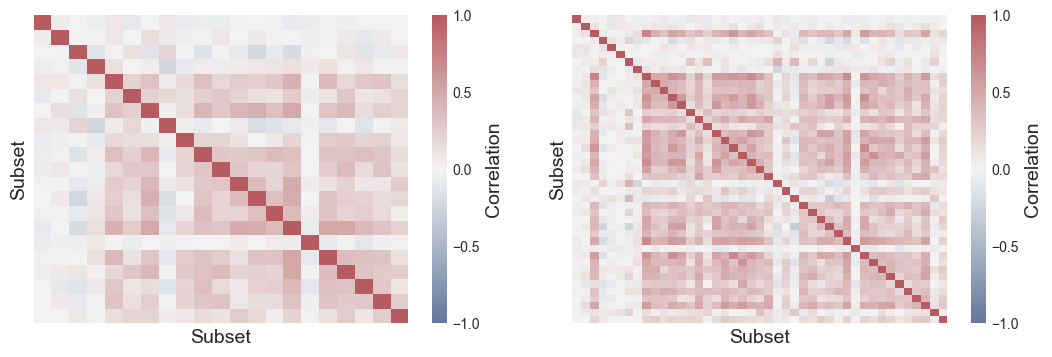

In [27]:
from Code.som_plots import plot_subset_heatmaps

plot_subset_heatmaps(train_returns, subset = subset_data["MST"], sub_type = "MST")
plt.savefig(fig_path + 'MST_both_subset_heatmap.png', bbox_inches='tight')

In [28]:
from Code.functions import compare_subset_stat

tab = compare_subset_stat(train_returns, subset_data["MST"])
print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrr}
\hline
                             &   Small Subset &   Large Subset \\
\hline
 n                           &          21.00 &          43.00 \\
 Avg. annualized returns (\%) &           0.92 &           0.88 \\
 Avg. annualized std (\%)     &          15.93 &          15.04 \\
 Avg. Sharpe Ratio           &           0.34 &           0.39 \\
 Avg. Starr Ratio            &           1.14 &           1.38 \\
 PDI                         &          13.08 &          19.18 \\
 Avg. pair-wise correlation  &           0.13 &           0.19 \\
\hline
\end{tabular}


In [29]:
# Region
tab = etf_data[etf_data["Symbol"].isin(subset_data["MST"]["Large"])].value_counts("region")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))
print("\n")

# Asset class
tab = etf_data[etf_data["Symbol"].isin(subset_data["MST"]["Large"])].value_counts("Asset Class")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", intfmt="0.0f", tablefmt = "latex"))
print("\n")

# Region
tab = etf_data[etf_data["Symbol"].isin(subset_data["MST"]["Small"])].value_counts("region")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))
print("\n")

# Asset class
tab = etf_data[etf_data["Symbol"].isin(subset_data["MST"]["Small"])].value_counts("Asset Class")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", intfmt="0.0f", tablefmt = "latex"))

\begin{tabular}{lrr}
\hline
 region                &   Count &   Ratio (\%) \\
\hline
 North America         &   25.00 &       58.14 \\
 Emerging Asia Pacifi  &    4.00 &        9.30 \\
 Developed Market      &    3.00 &        6.98 \\
 Global                &    3.00 &        6.98 \\
 Developed Asia Pacifi &    2.00 &        4.65 \\
 Developed Europe      &    2.00 &        4.65 \\
 Latin America         &    2.00 &        4.65 \\
 Middle East           &    1.00 &        2.33 \\
 Undefined             &    1.00 &        2.33 \\
\hline
\end{tabular}


\begin{tabular}{lrr}
\hline
 Asset Class     &   Count &   Ratio (\%) \\
\hline
 Equity          &   25.00 &       58.14 \\
 Bond            &   12.00 &       27.91 \\
 Alternatives    &    1.00 &        2.33 \\
 Commodity       &    1.00 &        2.33 \\
 Currency        &    1.00 &        2.33 \\
 Multi-Asset     &    1.00 &        2.33 \\
 Preferred Stock &    1.00 &        2.33 \\
 Real Estate     &    1.00 &        2.33 \\
\hline
\e

## Cluster

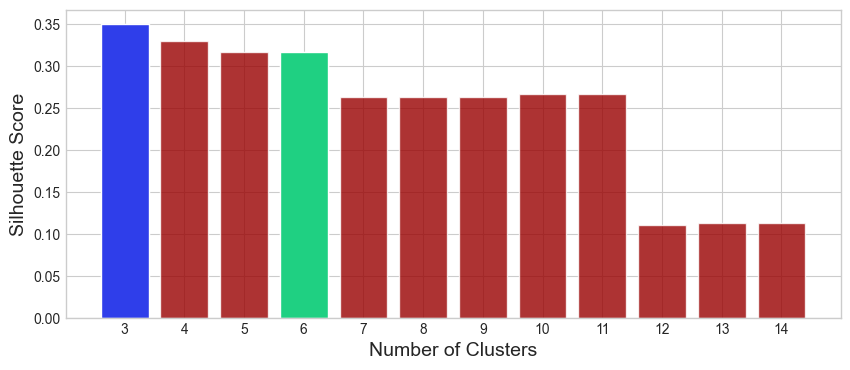

In [30]:
from Investment_Funnel_SOM.models.Clustering import cluster
from sklearn.metrics import silhouette_samples, silhouette_score   

cluster_df = train_st_returns[etf_symbols["universe"]]
# cluster_df = train_returns[etf_symbols["universe"]]

silhouette_avg = []
n_clusters_list = np.arange(3,15)
for i in n_clusters_list:
    # Apply the clustering algorithm to the node positions to extract the clusters
    hcluster_labels = np.array(cluster(cluster_df, n_clusters = i, dendrogram = False)["Complete_Corr"])
    silhouette_avg.append(silhouette_score(cluster_df.values.T, hcluster_labels))
    
plt.bar(n_clusters_list, silhouette_avg, alpha = 0.8)

plt.bar(n_clusters_list[0], silhouette_avg[0])
plt.bar(n_clusters_list[3], silhouette_avg[3])
plt.xticks(n_clusters_list)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
#plt.title("Cluster Silhouette Score")
plt.savefig(fig_path + 'Cluster_large_silhouette.png', bbox_inches='tight')
plt.show()

### Small

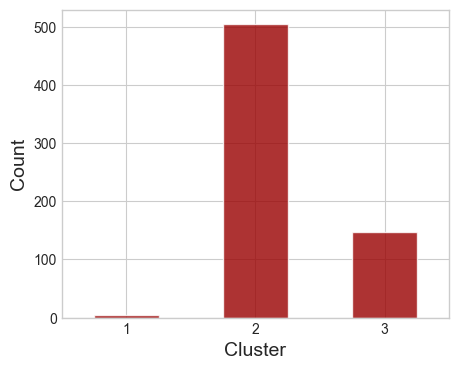

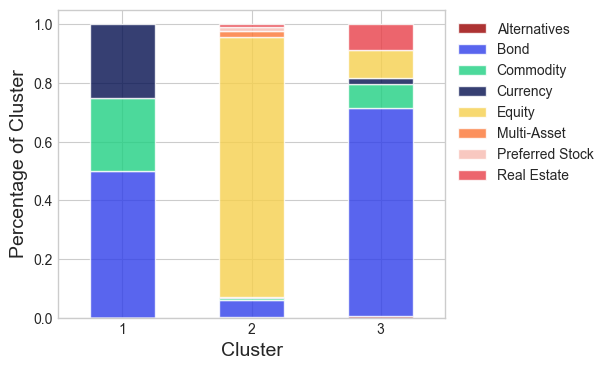

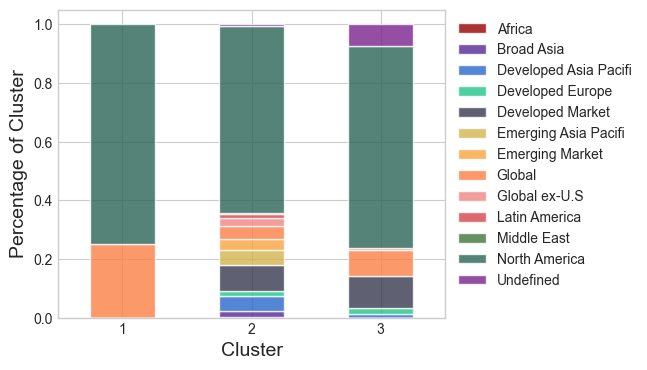

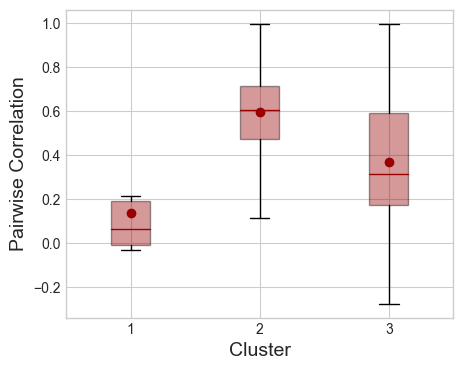

In [31]:
from Investment_Funnel_SOM.models.Clustering import cluster

# cluster_df = train_st_returns[etf_symbols["universe"]]
cluster_df = train_st_returns[etf_symbols["universe"]]

# CLUSTER DATA
n_clusters = 3
cluster_labels = cluster(cluster_df, n_clusters, dendrogram=False)["Complete_Corr"].values

etf_data["Cluster"] = cluster_labels

info_figsize = (5,4)

# fig density (1)
fig, ax = plt.subplots(figsize = info_figsize)
etf_data.value_counts("Cluster", sort = False).plot(kind = "bar", legend = False, ax = ax, alpha = 0.8)
#plt.title("Density")
plt.xticks(rotation = 0)
plt.xlabel("Cluster")
plt.ylabel("Count")

plt.savefig(fig_path + 'Cluster_small_info_(1).png', bbox_inches='tight')
plt.show()



# fig asset (2)
fig, ax = plt.subplots(figsize = info_figsize)
df = etf_data.groupby("Cluster")["Asset Class"].value_counts(normalize = True).to_frame()
df.columns = ["Count"]
df = df.reset_index().pivot(index = "Cluster", columns = "Asset Class", values = "Count")

df.plot(kind = "bar", stacked = True, ax = ax, alpha = 0.8)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.title("Asset Class Distribution")
plt.xticks(rotation = 0)
plt.xlabel("Cluster")
plt.ylabel("Percentage of Cluster")

plt.savefig(fig_path + 'Cluster_small_info_(2).png', bbox_inches='tight')
plt.show()



# fig region (3)
fig, ax = plt.subplots(figsize = info_figsize)
df = etf_data.groupby("Cluster")["region"].value_counts(normalize = True).to_frame()
df.columns = ["Count"]
df = df.reset_index().pivot(index = "Cluster", columns = "region", values = "Count")

df.plot(kind = "bar", stacked = True, ax = ax, alpha = 0.8, cmap = "dtu_colors_medium")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.title("Regional Distribution")
plt.xticks(rotation = 0)
plt.xlabel("Cluster")
plt.ylabel("Percentage of Cluster")

plt.savefig(fig_path + 'Cluster_small_info_(3).png', bbox_inches='tight')
plt.show()


# get pairvise correlation
pair_mean_corr = []
pair_corr = []
for cluster in np.unique(cluster_labels):
    
    cluster_returns = train_returns[etf_symbols["universe"]].iloc[:, cluster_labels == cluster]
    cluster_symbols = cluster_returns.columns.to_list()
    
    cluster_corr = cluster_returns.corr("spearman")
    
    pair_corr.append(cluster_corr.values[np.triu_indices(n = len(cluster_symbols), k=1)])
    pair_mean_corr.append(cluster_corr.values[np.triu_indices(n = len(cluster_symbols), k=1)].mean())

    
    
# fig corr (4)
fig, ax = plt.subplots(figsize = info_figsize)
meanprops = dict(marker='o', markerfacecolor = colors["DTU Red"], markeredgecolor = colors["DTU Red"])
bp = ax.boxplot(
    pair_corr, showfliers=False,
    medianprops=dict(color = colors["DTU Red"]),
    showmeans=True, meanline=False, meanprops=meanprops,
    patch_artist=True,
)
for patch in bp['boxes']:
    patch.set_facecolor(colors["DTU Red"])
    patch.set_alpha(0.4)

plt.xlabel("Cluster")
plt.ylabel("Pairwise Correlation")
#plt.title("Pairwise Correlation")

#plt.savefig(fig_path + 'Cluster_small_correlation_boxplot.png', bbox_inches='tight')
plt.savefig(fig_path + 'Cluster_small_info_(4).png', bbox_inches='tight')
plt.show()

In [32]:
from Code.functions import get_subset_stat

tab = {}
for group in etf_data.groupby("Cluster"):
    
    cluster = group[0] 
    cluster_df = group[1] 
    
    cluster_symbols = cluster_df["Symbol"]
    cluster_returns = train_returns[cluster_symbols]
    
    tab[f"Cluster {cluster}"] = {}
    tab[f"Cluster {cluster}"] = get_subset_stat(cluster_returns)
    
tab = pd.DataFrame(tab)
print(tabulate(tab, headers="keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrrr}
\hline
                             &   Cluster 1 &   Cluster 2 &   Cluster 3 \\
\hline
 n                           &        4.00 &      505.00 &      147.00 \\
 Avg. annualized returns (\%) &       -0.09 &        3.61 &        1.14 \\
 Avg. annualized std (\%)     &        8.86 &       15.88 &        8.18 \\
 Avg. Sharpe Ratio           &        0.49 &        0.30 &        0.55 \\
 Avg. Starr Ratio            &        1.69 &        0.86 &        2.07 \\
 PDI                         &        3.17 &       13.27 &       14.62 \\
 Avg. pair-wise correlation  &        0.14 &        0.60 &        0.37 \\
\hline
\end{tabular}


In [33]:
import heapq as hq
from Investment_Funnel_SOM.models.Clustering import cluster
from Code.som_plots import plot_subset_heatmap

# cluster_df = train_st_returns[etf_symbols["universe"]]
cluster_df = train_st_returns[etf_symbols["universe"]]

# CLUSTER DATA
n_clusters = 3
cluster_labels = cluster(cluster_df, n_clusters, dendrogram=False)["Complete_Corr"].values


n_from_cluster = 5
n_min_cluster = 20

cluster_subset = []
for cluster in np.unique(cluster_labels):
    
    cluster_df = train_returns[etf_symbols["universe"]].iloc[:, cluster_labels == cluster]
    cluster_symbols = cluster_df.columns.to_list()
    
    if len(cluster_symbols) >= n_min_cluster:     
        
        sharpe_returns = cluster_df
        sharpe_etfs = sharpe_returns.columns.to_list()

        sharpe = list(sharpe_ratio(sharpe_returns, "weekly"))
        n_largest_sharpe = hq.nlargest(n_from_cluster, sharpe)
        sharpe_winners = [sharpe_etfs[sharpe.index(s)] for s in n_largest_sharpe]

        starr_returns = sharpe_returns.loc[:, ~sharpe_returns.columns.isin(sharpe_winners)]
        starr_etfs = starr_returns.columns.to_list()

        starr = list(starr_ratio(starr_returns, "weekly"))
        n_largest_starr = hq.nlargest(n_from_cluster, starr)
        starr_winners = [starr_etfs[starr.index(s)] for s in n_largest_starr]

        cluster_winners = set(sharpe_winners + starr_winners)

        cluster_subset.extend(cluster_winners)
    else:
        
        # cluster_sharpe_ratios = sharpe_ratio(mst_cluster_df, "weekly")
        cluster_starr = list(starr_ratio(cluster_df, "weekly"))
        n_largest_starr = hq.nlargest(n_from_cluster, cluster_starr)
        
        cluster_winners = [cluster_symbols[cluster_starr.index(s)] for s in n_largest_starr]
        
        cluster_subset.extend(cluster_winners)
        
        
subset_data["Cluster"]["Small"] = cluster_subset

# plot_subset_heatmap(train_returns, cluster_subset, sub_type = "Cluster")
# plt.savefig(fig_path + 'Cluster_small_subset_heatmap.png', bbox_inches='tight')

In [34]:
# Selected assets
tab = {}
for group in etf_data[etf_data["Symbol"].isin(subset_data["Cluster"]["Small"])].groupby("Cluster"):
    
    cluster = group[0] 
    cluster_df = group[1] 
    
    cluster_symbols = cluster_df["Symbol"]
    cluster_returns = train_returns[cluster_symbols]
    
    tab[f"Cluster {cluster}"] = {}
    tab[f"Cluster {cluster}"] = get_subset_stat(cluster_returns)
    
tab = pd.DataFrame(tab)
print(tabulate(tab, headers="keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrrr}
\hline
                             &   Cluster 1 &   Cluster 2 &   Cluster 3 \\
\hline
 n                           &        4.00 &       10.00 &       10.00 \\
 Avg. annualized returns (\%) &       -0.09 &        7.02 &        1.36 \\
 Avg. annualized std (\%)     &        8.86 &        7.33 &        0.52 \\
 Avg. Sharpe Ratio           &        0.49 &        0.97 &        3.25 \\
 Avg. Starr Ratio            &        1.69 &        2.98 &       13.91 \\
 PDI                         &        3.17 &        4.04 &        7.46 \\
 Avg. pair-wise correlation  &        0.14 &        0.41 &        0.11 \\
\hline
\end{tabular}


### Large

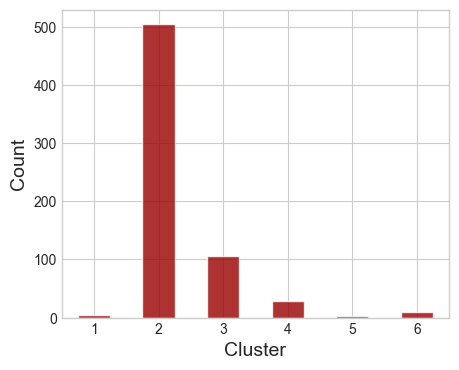

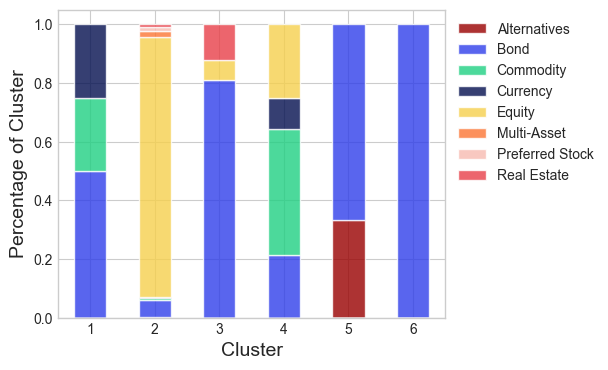

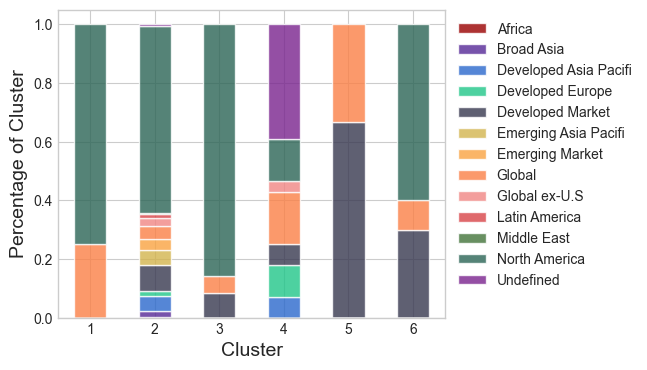

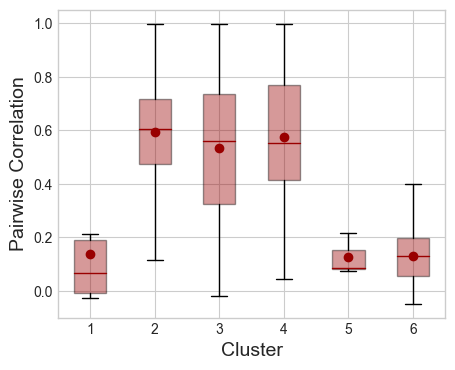

In [35]:
from Investment_Funnel_SOM.models.Clustering import cluster

# cluster_df = train_st_returns[etf_symbols["universe"]]
cluster_df = train_st_returns[etf_symbols["universe"]]

# CLUSTER DATA
n_clusters = 6
cluster_labels = cluster(cluster_df, n_clusters, dendrogram=False)["Complete_Corr"].values

etf_data["Cluster"] = cluster_labels

info_figsize = (5,4)

# fig density (1)
fig, ax = plt.subplots(figsize = info_figsize)
etf_data.value_counts("Cluster", sort = False).plot(kind = "bar", legend = False, ax = ax, alpha = 0.8)
#plt.title("Density")
plt.xticks(rotation = 0)
plt.xlabel("Cluster")
plt.ylabel("Count")

plt.savefig(fig_path + 'Cluster_large_info_(1).png', bbox_inches='tight')
plt.show()



# fig asset (2)
fig, ax = plt.subplots(figsize = info_figsize)
df = etf_data.groupby("Cluster")["Asset Class"].value_counts(normalize = True).to_frame()
df.columns = ["Count"]
df = df.reset_index().pivot(index = "Cluster", columns = "Asset Class", values = "Count")

df.plot(kind = "bar", stacked = True, ax = ax, alpha = 0.8)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.title("Asset Class Distribution")
plt.xticks(rotation = 0)
plt.xlabel("Cluster")
plt.ylabel("Percentage of Cluster")

plt.savefig(fig_path + 'Cluster_large_info_(2).png', bbox_inches='tight')
plt.show()



# fig region (3)
fig, ax = plt.subplots(figsize = info_figsize)
df = etf_data.groupby("Cluster")["region"].value_counts(normalize = True).to_frame()
df.columns = ["Count"]
df = df.reset_index().pivot(index = "Cluster", columns = "region", values = "Count")

df.plot(kind = "bar", stacked = True, ax = ax, alpha = 0.8, cmap = "dtu_colors_medium")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.title("Regional Distribution")
plt.xticks(rotation = 0)
plt.xlabel("Cluster")
plt.ylabel("Percentage of Cluster")

plt.savefig(fig_path + 'Cluster_large_info_(3).png', bbox_inches='tight')
plt.show()


# get pairvise correlation
pair_mean_corr = []
pair_corr = []
for cluster in np.unique(cluster_labels):
    
    cluster_returns = train_returns[etf_symbols["universe"]].iloc[:, cluster_labels == cluster]
    cluster_symbols = cluster_returns.columns.to_list()
    
    cluster_corr = cluster_returns.corr("spearman")
    
    pair_corr.append(cluster_corr.values[np.triu_indices(n = len(cluster_symbols), k=1)])
    pair_mean_corr.append(cluster_corr.values[np.triu_indices(n = len(cluster_symbols), k=1)].mean())

    
    
# fig corr (4)
fig, ax = plt.subplots(figsize = info_figsize)
meanprops = dict(marker='o', markerfacecolor = colors["DTU Red"], markeredgecolor = colors["DTU Red"])
bp = ax.boxplot(
    pair_corr, showfliers=False,
    medianprops=dict(color = colors["DTU Red"]),
    showmeans=True, meanline=False, meanprops=meanprops,
    patch_artist=True,
)
for patch in bp['boxes']:
    patch.set_facecolor(colors["DTU Red"])
    patch.set_alpha(0.4)

plt.xlabel("Cluster")
plt.ylabel("Pairwise Correlation")
#plt.title("Pairwise Correlation")

#plt.savefig(fig_path + 'Cluster_small_correlation_boxplot.png', bbox_inches='tight')
plt.savefig(fig_path + 'Cluster_large_info_(4).png', bbox_inches='tight')
plt.show()

In [36]:
tab = {}
for group in etf_data.groupby("Cluster"):
    
    cluster = group[0] 
    cluster_df = group[1] 
    
    cluster_symbols = cluster_df["Symbol"]
    cluster_returns = train_returns[cluster_symbols]
    
    tab[f"Cluster {cluster}"] = {}
    tab[f"Cluster {cluster}"] = get_subset_stat(cluster_returns)
    
tab = pd.DataFrame(tab)
print(tabulate(tab, headers="keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrrrrrr}
\hline
                             &   Cluster 1 &   Cluster 2 &   Cluster 3 &   Cluster 4 &   Cluster 5 &   Cluster 6 \\
\hline
 n                           &        4.00 &      505.00 &      106.00 &       28.00 &        3.00 &       10.00 \\
 Avg. annualized returns (\%) &       -0.09 &        3.61 &        1.67 &       -0.78 &        0.11 &        1.18 \\
 Avg. annualized std (\%)     &        8.86 &       15.88 &        5.80 &       20.60 &        2.29 &        0.48 \\
 Avg. Sharpe Ratio           &        0.49 &        0.30 &        0.46 &       -0.05 &        0.90 &        3.13 \\
 Avg. Starr Ratio            &        1.69 &        0.86 &        1.56 &       -0.16 &        3.38 &       13.28 \\
 PDI                         &        3.17 &       13.27 &        8.53 &        3.75 &        2.61 &        7.41 \\
 Avg. pair-wise correlation  &        0.14 &        0.60 &        0.53 &        0.57 &        0.13 &        0.13 \\
\hline
\end{tabular}


In [37]:
import heapq as hq
from Investment_Funnel_SOM.models.Clustering import cluster
from Code.som_plots import plot_subset_heatmap

# cluster_df = train_st_returns[etf_symbols["universe"]]
cluster_df = train_st_returns[etf_symbols["universe"]]

# CLUSTER DATA
n_clusters = 6
cluster_labels = cluster(cluster_df, n_clusters, dendrogram=False)["Complete_Corr"].values


n_from_cluster = 5
n_min_cluster = 20

cluster_subset = []
for cluster in np.unique(cluster_labels):
    
    cluster_df = train_returns[etf_symbols["universe"]].iloc[:, cluster_labels == cluster]
    cluster_symbols = cluster_df.columns.to_list()
    
    if len(cluster_symbols) >= n_min_cluster:     
        
        sharpe_returns = cluster_df
        sharpe_etfs = sharpe_returns.columns.to_list()

        sharpe = list(sharpe_ratio(sharpe_returns, "weekly"))
        n_largest_sharpe = hq.nlargest(n_from_cluster, sharpe)
        sharpe_winners = [sharpe_etfs[sharpe.index(s)] for s in n_largest_sharpe]

        starr_returns = sharpe_returns.loc[:, ~sharpe_returns.columns.isin(sharpe_winners)]
        starr_etfs = starr_returns.columns.to_list()

        starr = list(starr_ratio(starr_returns, "weekly"))
        n_largest_starr = hq.nlargest(n_from_cluster, starr)
        starr_winners = [starr_etfs[starr.index(s)] for s in n_largest_starr]

        cluster_winners = set(sharpe_winners + starr_winners)

        cluster_subset.extend(cluster_winners)
    else:
        
        # cluster_sharpe_ratios = sharpe_ratio(mst_cluster_df, "weekly")
        cluster_starr = list(starr_ratio(cluster_df, "weekly"))
        n_largest_starr = hq.nlargest(n_from_cluster, cluster_starr)
        
        cluster_winners = [cluster_symbols[cluster_starr.index(s)] for s in n_largest_starr]
        
        cluster_subset.extend(cluster_winners)
        
        
subset_data["Cluster"]["Large"] = cluster_subset

# plot_subset_heatmap(train_returns, cluster_subset, sub_type = "Cluster")
# plt.savefig(fig_path + 'Cluster_large_subset_heatmap.png', bbox_inches='tight')

In [38]:
# Selected assets
tab = {}
for group in etf_data[etf_data["Symbol"].isin(subset_data["Cluster"]["Large"])].groupby("Cluster"):
    
    cluster = group[0] 
    cluster_df = group[1] 
    
    cluster_symbols = cluster_df["Symbol"]
    cluster_returns = train_returns[cluster_symbols]
    
    tab[f"Cluster {cluster}"] = {}
    tab[f"Cluster {cluster}"] = get_subset_stat(cluster_returns)
    
tab = pd.DataFrame(tab)
print(tabulate(tab, headers="keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrrrrrr}
\hline
                             &   Cluster 1 &   Cluster 2 &   Cluster 3 &   Cluster 4 &   Cluster 5 &   Cluster 6 \\
\hline
 n                           &        4.00 &       10.00 &       10.00 &       10.00 &        3.00 &        5.00 \\
 Avg. annualized returns (\%) &       -0.09 &        7.02 &        1.70 &        2.14 &        0.11 &        1.18 \\
 Avg. annualized std (\%)     &        8.86 &        7.33 &        1.48 &       17.93 &        2.29 &        0.27 \\
 Avg. Sharpe Ratio           &        0.49 &        0.97 &        1.21 &        0.10 &        0.90 &        4.30 \\
 Avg. Starr Ratio            &        1.69 &        2.98 &        4.34 &        0.35 &        3.38 &       19.93 \\
 PDI                         &        3.17 &        4.04 &        4.13 &        2.26 &        2.61 &        3.84 \\
 Avg. pair-wise correlation  &        0.14 &        0.41 &        0.46 &        0.62 &        0.13 &        0.15 \\
\hline
\end{tabular}


### Overview

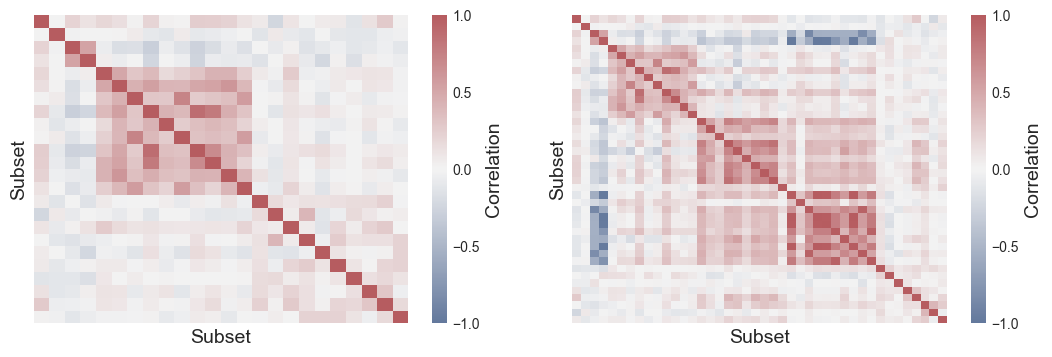

In [39]:
from Code.som_plots import plot_subset_heatmaps

plot_subset_heatmaps(train_returns, subset = subset_data["Cluster"], sub_type = "Cluster")
plt.savefig(fig_path + 'Cluster_both_subset_heatmap.png', bbox_inches='tight')

In [40]:
from Code.functions import compare_subset_stat

tab = compare_subset_stat(train_returns, subset_data["Cluster"])
print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrr}
\hline
                             &   Small Subset &   Large Subset \\
\hline
 n                           &          24.00 &          42.00 \\
 Avg. annualized returns (\%) &           3.47 &           2.72 \\
 Avg. annualized std (\%)     &           4.75 &           7.41 \\
 Avg. Sharpe Ratio           &           1.84 &           1.17 \\
 Avg. Starr Ratio            &           7.32 &           4.60 \\
 PDI                         &          12.53 &          13.79 \\
 Avg. pair-wise correlation  &           0.09 &           0.12 \\
\hline
\end{tabular}


In [41]:
# Region
tab = etf_data[etf_data["Symbol"].isin(subset_data["Cluster"]["Large"])].value_counts("region")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))
print("\n")

# Asset class
tab = etf_data[etf_data["Symbol"].isin(subset_data["Cluster"]["Large"])].value_counts("Asset Class")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", intfmt="0.0f", tablefmt = "latex"))
print("\n")

# Region
tab = etf_data[etf_data["Symbol"].isin(subset_data["Cluster"]["Small"])].value_counts("region")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))
print("\n")

# Asset class
tab = etf_data[etf_data["Symbol"].isin(subset_data["Cluster"]["Small"])].value_counts("Asset Class")
tab = pd.DataFrame(tab, columns=["Count"])
tab["Ratio (%)"] = (tab["Count"]/tab["Count"].sum()) * 100

print(tabulate(tab, headers = "keys", floatfmt="0.2f", intfmt="0.0f", tablefmt = "latex"))

\begin{tabular}{lrr}
\hline
 region                &   Count &   Ratio (\%) \\
\hline
 North America         &   18.00 &       42.86 \\
 Developed Market      &    9.00 &       21.43 \\
 Global                &    6.00 &       14.29 \\
 Undefined             &    5.00 &       11.90 \\
 Emerging Market       &    2.00 &        4.76 \\
 Developed Asia Pacifi &    1.00 &        2.38 \\
 Global ex-U.S         &    1.00 &        2.38 \\
\hline
\end{tabular}


\begin{tabular}{lrr}
\hline
 Asset Class   &   Count &   Ratio (\%) \\
\hline
 Bond          &   28.00 &       66.67 \\
 Commodity     &    6.00 &       14.29 \\
 Equity        &    5.00 &       11.90 \\
 Currency      &    2.00 &        4.76 \\
 Alternatives  &    1.00 &        2.38 \\
\hline
\end{tabular}


\begin{tabular}{lrr}
\hline
 region           &   Count &   Ratio (\%) \\
\hline
 North America    &   14.00 &       58.33 \\
 Developed Market &    4.00 &       16.67 \\
 Global           &    3.00 &       12.50 \\
 Emerging Mark

# Tables

### Gather Subsets

In [42]:
subset_names = list(subset_data.keys())
sizes = ["Small", "Large"]

subset_data_reordered = {}
for s in sizes:
    subset_data_reordered[s] = {}
    for n in subset_names:
        subset_data_reordered[s][n] = subset_data[n][s]

### Small

In [43]:
from Code.functions import get_subset_stat
    
tab = {}
for subset_name, subset in subset_data_reordered["Small"].items():
    subset_returns = train_returns[subset]
    
    tab[subset_name] = get_subset_stat(subset_returns)
    


tab = pd.DataFrame(tab)
print(tabulate(tab, headers="keys", floatfmt=".2f", tablefmt = "latex"))

\begin{tabular}{lrrrrr}
\hline
                             &   Universe &   SOM-Cluster &   Cluster &   SOM-MST &   MST \\
\hline
 n                           &     656.00 &         24.00 &     24.00 &     27.00 & 21.00 \\
 Avg. annualized returns (\%) &       3.03 &          5.20 &      3.47 &      2.50 &  0.92 \\
 Avg. annualized std (\%)     &      14.11 &          5.41 &      4.75 &     15.64 & 15.93 \\
 Avg. Sharpe Ratio           &       0.36 &          1.48 &      1.84 &      0.37 &  0.34 \\
 Avg. Starr Ratio            &       1.14 &          5.60 &      7.32 &      1.19 &  1.14 \\
 PDI                         &      19.17 &          8.34 &     12.53 &     12.74 & 13.08 \\
 Avg. pair-wise correlation  &       0.38 &          0.24 &      0.09 &      0.21 &  0.13 \\
\hline
\end{tabular}


In [44]:
tab = pd.DataFrame(index = np.unique(etf_data["Asset Class"]))
for port, sub in subset_data_reordered["Small"].items():
    port_data = etf_data[etf_data["Symbol"].isin(sub)]
    
    port_ac = port_data.value_counts("Asset Class", normalize = True)
    port_ac.name = port
    tab = pd.concat([tab, port_ac], axis = 1)
    
tab = tab.apply(lambda x: round(x * 100, 2))
print(tabulate(tab.fillna("-"), headers="keys", floatfmt=".2f", tablefmt = "simple"))

                   Universe  SOM-Cluster    Cluster    SOM-MST    MST
---------------  ----------  -------------  ---------  ---------  -----
Alternatives           0.30  -              -          -          4.76
Bond                  20.58  70.83          79.17      18.52      28.57
Commodity              2.59  -              4.17       3.7        4.76
Currency               0.76  -              4.17       3.7        4.76
Equity                70.43  25.0           12.5       66.67      52.38
Multi-Asset            1.68  -              -          3.7        -
Preferred Stock        0.91  4.17           -          3.7        4.76
Real Estate            2.74  -              -          -          -


In [45]:
tab = pd.DataFrame(index = np.unique(etf_data["region"]))
for port, sub in subset_data_reordered["Small"].items():
    port_data = etf_data[etf_data["Symbol"].isin(sub)]
    
    port_ac = port_data.value_counts("region", normalize = True)
    port_ac.name = port
    tab = pd.concat([tab, port_ac], axis = 1)
    
tab = tab.apply(lambda x: round(x * 100, 2))
print(tabulate(tab.fillna("-"), headers="keys", floatfmt=".2f", tablefmt = "simple"))

                         Universe  SOM-Cluster    Cluster    SOM-MST    MST
---------------------  ----------  -------------  ---------  ---------  -----
Africa                       0.15  -              -          -          -
Broad Asia                   1.68  -              -          -          -
Developed Asia Pacifi        4.12  -              -          7.41       4.76
Developed Europe             1.83  -              -          -          9.52
Developed Market             9.30  16.67          16.67      11.11      4.76
Emerging Asia Pacifi         3.96  -              -          11.11      14.29
Emerging Market              2.90  12.5           8.33       -          -
Global                       5.34  4.17           12.5       7.41       9.52
Global ex-U.S                2.44  4.17           4.17       -          -
Latin America                1.07  -              -          3.7        4.76
Middle East                  0.15  -              -          -          4.76
North Amer

### Large

In [46]:
from Code.functions import get_subset_stat
    
tab = {}
for subset_name, subset in subset_data_reordered["Large"].items():
    subset_returns = train_returns[subset]
    
    tab[subset_name] = get_subset_stat(subset_returns)
    


tab = pd.DataFrame(tab)
print(tabulate(tab, headers="keys", floatfmt=".2f", tablefmt = "latex"))

\begin{tabular}{lrrrrr}
\hline
                             &   Universe &   SOM-Cluster &   Cluster &   SOM-MST &   MST \\
\hline
 n                           &     656.00 &         40.00 &     42.00 &     57.00 & 43.00 \\
 Avg. annualized returns (\%) &       3.03 &          5.72 &      2.72 &      2.93 &  0.88 \\
 Avg. annualized std (\%)     &      14.11 &          6.36 &      7.41 &     15.26 & 15.04 \\
 Avg. Sharpe Ratio           &       0.36 &          1.36 &      1.17 &      0.43 &  0.39 \\
 Avg. Starr Ratio            &       1.14 &          5.13 &      4.60 &      1.50 &  1.38 \\
 PDI                         &      19.17 &         10.20 &     13.79 &     17.69 & 19.18 \\
 Avg. pair-wise correlation  &       0.38 &          0.23 &      0.12 &      0.25 &  0.19 \\
\hline
\end{tabular}


In [47]:
tab = pd.DataFrame(index = np.unique(etf_data["Asset Class"]))
for port, sub in subset_data_reordered["Large"].items():
    port_data = etf_data[etf_data["Symbol"].isin(sub)]
    
    port_ac = port_data.value_counts("Asset Class", normalize = True)
    port_ac.name = port
    tab = pd.concat([tab, port_ac], axis = 1)
    
tab = tab.apply(lambda x: round(x * 100, 2))
print(tabulate(tab.fillna("-"), headers="keys", floatfmt=".2f", tablefmt = "simple"))

                   Universe  SOM-Cluster    Cluster      SOM-MST    MST
---------------  ----------  -------------  ---------  ---------  -----
Alternatives           0.30  -              2.38            1.75   2.33
Bond                  20.58  65.0           66.67          15.79  27.91
Commodity              2.59  -              14.29           3.51   2.33
Currency               0.76  -              4.76            5.26   2.33
Equity                70.43  32.5           11.9           66.67  58.14
Multi-Asset            1.68  -              -               3.51   2.33
Preferred Stock        0.91  2.5            -               1.75   2.33
Real Estate            2.74  -              -               1.75   2.33


In [48]:
tab = pd.DataFrame(index = np.unique(etf_data["region"]))
for port, sub in subset_data_reordered["Large"].items():
    port_data = etf_data[etf_data["Symbol"].isin(sub)]
    
    port_ac = port_data.value_counts("region", normalize = True)
    port_ac.name = port
    tab = pd.concat([tab, port_ac], axis = 1)
    
tab = tab.apply(lambda x: round(x * 100, 2))
print(tabulate(tab.fillna("-"), headers="keys", floatfmt=".2f", tablefmt = "simple"))

                         Universe  SOM-Cluster    Cluster    SOM-MST    MST
---------------------  ----------  -------------  ---------  ---------  -----
Africa                       0.15  -              -          -          -
Broad Asia                   1.68  -              -          -          -
Developed Asia Pacifi        4.12  -              2.38       7.02       4.65
Developed Europe             1.83  -              -          1.75       4.65
Developed Market             9.30  15.0           21.43      10.53      6.98
Emerging Asia Pacifi         3.96  -              -          7.02       9.3
Emerging Market              2.90  7.5            4.76       1.75       -
Global                       5.34  5.0            14.29      8.77       6.98
Global ex-U.S                2.44  5.0            2.38       -          -
Latin America                1.07  -              -          3.51       4.65
Middle East                  0.15  -              -          1.75       2.33
North Americ

# Plots

### Small

In [49]:
# port_returns = pd.DataFrame()
# port_names = []
# port_pdi = []
# port_sharpe = []
# port_starr = []
# 
# for name , symbol_list in subset_data_reordered["Small"].items():
#     
#     port_returns[name] = test_returns[symbol_list].mean(axis=1)
#     
#     pdi = get_pdi(test_returns[symbol_list])
#     sharpe = sharpe_ratio(pd.DataFrame(test_returns[symbol_list]), "weekly").mean()
#     starr = starr_ratio(pd.DataFrame(test_returns[symbol_list]), "weekly").mean()
#     
#     port_names.append(name)
#     port_pdi.append(pdi)
#     port_sharpe.append(sharpe)
#     port_starr.append(starr)
#     
# ratio_df = pd.DataFrame({
#     "Sharpe Ratio": port_sharpe,
#     "Starr Ratio": port_starr
# }, index = port_names)
# 
# 
# fig = plt.figure(figsize=(12, 10))
# spec = fig.add_gridspec(
#     2,2, 
#     wspace = 0.25, 
#     hspace=0.25
# )
# 
# ax = fig.add_subplot(spec[0,:])
# (np.cumprod(1+port_returns) * 100).plot(ax = ax)
# plt.title("Subsets Comparison")
# plt.xlabel("Date")
# plt.ylabel("value")
#     
# 
# ax = fig.add_subplot(spec[1,0])   
# plt.barh(port_names, port_pdi, alpha = 0.8)
# ax.invert_yaxis()
# plt.title("PDIs")
# plt.xlabel("PDI")
# 
# ax = fig.add_subplot(spec[1,1])
# ratio_df.plot(kind = "barh", alpha = 0.8, width = 0.8, ax = ax)
# ax.invert_yaxis()
# plt.title("Average Performance Ratios")
# plt.xlabel("Ratio")
# 
# plt.savefig(fig_path + 'small_subset_valueplot.png', bbox_inches='tight')
# plt.show()

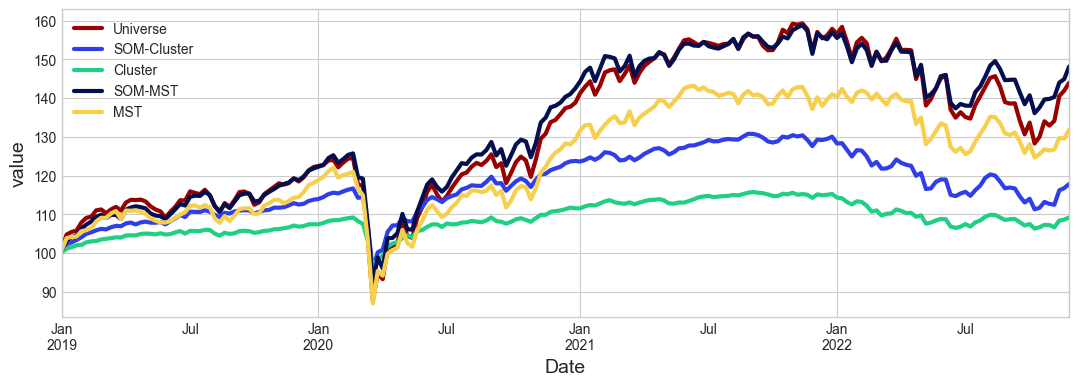

In [50]:
port_returns = pd.DataFrame()

for name , symbol_list in subset_data_reordered["Small"].items():
    
    port_returns[name] = test_returns[symbol_list].mean(axis=1)


fig,ax = plt.subplots(figsize=(13, 4))

(np.cumprod(1+port_returns) * 100).plot(ax = ax)
#plt.title("Subsets Comparison (small)")
plt.xlabel("Date")
plt.ylabel("value")
    

plt.savefig(fig_path + 'small_subset_valueplot.png', bbox_inches='tight')
plt.show()

### Large

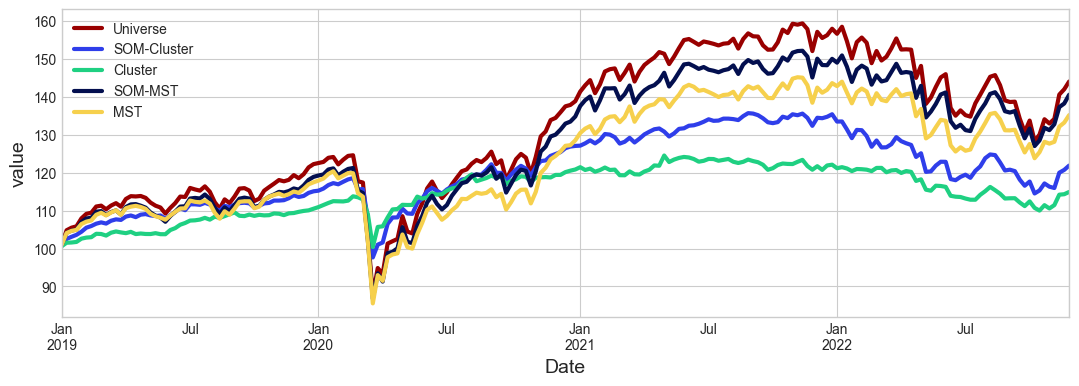

In [51]:
port_returns = pd.DataFrame()

for name , symbol_list in subset_data_reordered["Large"].items():
    
    port_returns[name] = test_returns[symbol_list].mean(axis=1)


fig,ax = plt.subplots(figsize=(13, 4))

(np.cumprod(1+port_returns) * 100).plot(ax = ax)
#plt.title("Subsets Comparison (large)")
plt.xlabel("Date")
plt.ylabel("value")
    

plt.savefig(fig_path + 'large_subset_valueplot.png', bbox_inches='tight')
plt.show()

# Test returns statistics

In [52]:
from Code.functions import get_annualized_returns, get_annualized_std, sharpe_ratio, starr_ratio

etf_data["Annualized mean returns (Test)"] = get_annualized_returns(train_returns[etf_symbols["universe"]], "weekly")
etf_data["Annualized std (Test)"] = get_annualized_std(train_returns[etf_symbols["universe"]], "weekly")
etf_data["Annualized sharpe (Test)"] = sharpe_ratio(train_returns[etf_symbols["universe"]], "weekly")

etf_data["Annualized starr (Test)"] = starr_ratio(train_returns[etf_symbols["universe"]], "weekly")

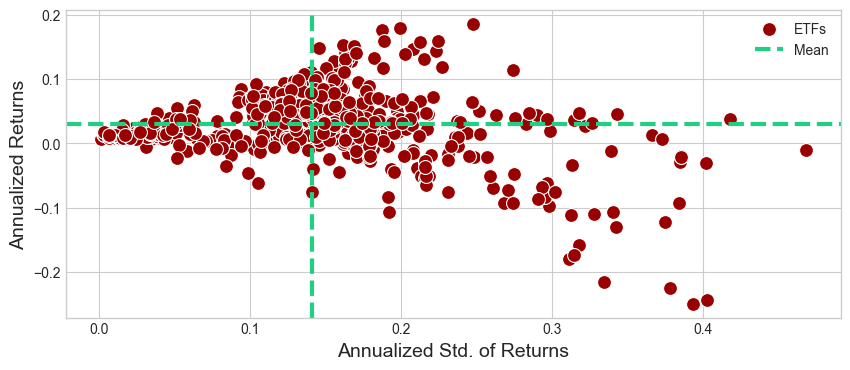

In [53]:

sns.scatterplot(
    data = etf_data,
    x = "Annualized std (Test)",
    y = "Annualized mean returns (Test)",
    label = "ETFs"
)

plt.axhline(y = etf_data["Annualized mean returns (Test)"].mean(), color = colors["DTU Green"], label = "Mean", linestyle = "--")
plt.axvline(x = etf_data["Annualized std (Test)"].mean(), color = colors["DTU Green"], linestyle = "--")

tick_loc = ax.get_yticks()
tick_labels = [f"{tick*100:0.1f} %"  for tick in tick_loc]
ax.yaxis.set_major_locator(mticker.FixedLocator(tick_loc))
ax.set_yticklabels(tick_labels)

#plt.title("ETF Universe Returns")
plt.xlabel("Annualized Std. of Returns")
plt.ylabel("Annualized Returns")
plt.legend()

# plt.savefig(fig_path + 'insights_return_distribution.png', bbox_inches='tight')
plt.show()

# Store Data

In [54]:
# # to json
# with open("Data/Data_ETFs_Subsets(Both).json", "w") as outfile:
#     # Write to json file
#     json.dump(subset_data_reordered, outfile)
# 
# # to json
# with open("Data/Data_ETFs_Subsets(Small).json", "w") as outfile:
#     # Write to json file
#     json.dump(subset_data_reordered["Small"], outfile)
# 
# # to json
# with open("Data/Data_ETFs_Subsets(Large).json", "w") as outfile:
#     # Write to json file
#     json.dump(subset_data_reordered["Large"], outfile)# 